In [1]:
from autograd import numpy as np
from autograd import grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

Some formulas

#### Objective: 
$$\nabla_{\theta,\phi} ELBO (\theta, q_{\phi}) = \sum_{n} \mathbb{E}_{q_{\phi}(z_n)} \log p_{\theta}(y_n|z_n) - D_{KL}[q_{\phi}(z_n) || p_{\theta}(z_n) ]$$

Assume $ p_{\theta}(z_n)$ has a normal prior $\mathcal{N}(0,I)$. Let the latent space have J dimensions, i.e. $\mu_n = [\mu_{1_n}, \ldots, \mu_{J_n}]$ and 
$\Sigma_n = \begin{bmatrix} \sigma_{1_n}^2 &\ldots &0 \\
\vdots & \ddots & \vdots\\
0 & \ldots & \sigma_{J_n}^2\\
\end{bmatrix}$

So, $- D_{KL}[q_{\phi}(z_n) || p_{\theta}(z_n) ] = \frac{1}{2} \sum_{j=1}^J (1+log(\sigma_{j_n}^2 )- \mu_{j_n}^2 - \sigma_{j_n}^2 )$

---

Toy example for 1 dimensional data and 1 dimensional latent space

> FYI I might have mixed up variance and standard deviation in diff places so that's fun

In [2]:
# just setting these as examples 
#y_n is one data point, L is the number of samples to estimate the expectation of the likelihood,
# sigma data is the standard deviation of the data
y_n = 0.24
L = 10
sigma_data = 0.5

In [3]:
# define inference model function
def g_phi(phi1, phi2, y_n):
    '''
    phi1 is a number
    phi2 is a number
    y_n is ONE 1-D data point 
    '''
    mu_n = phi1 * y_n 
    std_n = np.abs(phi2 * y_n) # added abs to make this positive always
    
    return mu_n, std_n

In [4]:
# define likelihood model function
def f_theta(theta, z_n):
    '''
    This is the prediction function. 
    
    theta: one number
    z_n: ONE 1-D sampled from 
    '''
    return theta * z_n

In [5]:
# monte carlo to get expectation of the likelihood
## I added 0.000001 to help the log
def monte_carlo_expectation(theta1, mu_n, std_n, L, y_n, sigma_data):
    
    # sample L latent variables - dis cray
    seed = npr.RandomState(10)
    z_n = seed.randn(L) * std_n + mu_n
    
    # get predictions using the prediction function, i.e. f_theta
    y_n_pred = f_theta(theta1, z_n) # this is an array bc z_n is an array
    y_n_full = np.repeat(y_n, y_n_pred.shape[0])
    
    # get log likelihood of observed data
    ll = np.mean(-1/2 * np.log(2 * np.pi  * sigma_data**2 + 0.0000001) - \
                 ((y_n_pred - y_n_full)**2/(-2 * sigma_data**2)))
    return ll

In [6]:
# define objective here, which is -(loglikelihood + -KL)
def objective(phi1, phi2, theta1, 
                y_n = y_n, L = L, sigma_data = sigma_data):
    '''
    three unknowns - phi1, phi2, theta1
    '''
    # two components
    # Likelihood - Monte Carlo
    mu_n, std_n = g_phi(phi1, phi2, y_n)
    
    ll = monte_carlo_expectation(theta1, mu_n, std_n, L, y_n, sigma_data)        
    
    # KL divergence - closed form - latent space in 1D
    negKL = 1/2 * (1 + np.log(std_n**2 + 0.0000001) - mu_n**2 - std_n**2)
    
    return -(ll + negKL)

In [7]:
## these are little checks 
# objective(phi1 = 1, phi2 = 0.1, theta1 = 1, y_n = 2.4, L = 100000, sigma_data = 0.5)

In [8]:
# grad(objective,2)(1.0, 0.1, 1.)

### Example

1D data  
1D latent space

In [9]:
# generate some fake data f_theta(z) =  2 z + 2, z ~ N(0,1)
np.random.seed(100)
data = 2 * np.random.normal(0,1,size = 1000) + 2

In [10]:
# init_params
phi1, phi2, theta1 = 1., 1., 1.
L = 1e6
sigma_data = 2
learning_rate = 0.00001
n_iter = 20

In [23]:
# very basic impl of running gradient descent. We should make this minibatch SGD

for _ in tqdm(range(n_iter)):
    
#     for y_n in tqdm(range(data.shape[0])):
    for y_n in (range(data.shape[0])):
#         print('objective', objective(phi1, phi2, theta1))
#         print('grad objective' ,grad(objective,0)(phi1, phi2, theta1))
        # phi1
        phi1_new = phi1 - learning_rate * grad(objective,0)(phi1, phi2, theta1)
        # phi1
        phi2_new = phi2 - learning_rate * grad(objective,1)(phi1, phi2, theta1)
        # phi1
        theta1_new = theta1 - learning_rate * grad(objective,2)(phi1, phi2, theta1)
        # update
        phi1, phi2, theta1 = phi1_new, phi2_new, theta1_new

In [25]:
phi1, phi2, theta1

(0.9928198641456137, 1.714089007197221, 1.261448424785953)

In [26]:
## make fake data
new_y = []
for i in data:
    m,s = g_phi(phi1, phi2, i)
    new_y.append(f_theta(theta1, np.random.normal(m,s)))

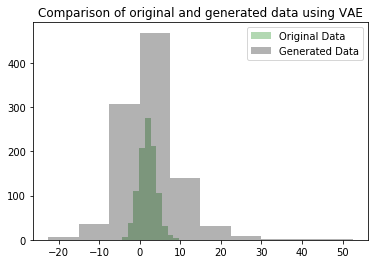

In [28]:
plt.hist(data,  bins = 10, color = 'g', alpha = 0.3, label = 'Original Data');
plt.hist(new_y,  bins = 10, color = 'k', alpha = 0.3, label = 'Generated Data')
plt.title('Comparison of original and generated data using VAE')
plt.legend();


---